In [1]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")


Warning message:
“package ‘rlang’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.4.3”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      mask

In [337]:
# Data operations
group_data <- function(df, grouping_feature) {
    # Takes Sherpa dataframe and returns dataframe with 
    # Lambda (i.e. group), Group mean and Psi
    #
    # Args:
    #     df: Sherpa output dataframe.
    #     grouping_feature: feature to group by.
    #
    # Returns:
    #     tbl: Lambda (i.e. group), Group mean and Psi
    names(df)[names(df) == grouping_feature] <- 'grouping_feature'
    df <- as.tibble(df)
    grpdf <- df %>% group_by_at('grouping_feature') %>%
            summarise(mean=mean(Objective), count=n()) %>%
            filter(count==25) %>%
            arrange(mean) %>%
            mutate(Lambda = 1:n()) %>%
            inner_join(df, by='grouping_feature') %>%
            rename(Psi=Objective, Mean=mean) %>%
            select(Lambda, Psi)
    return(grpdf)
}

subsample_groups <- function(tbl, num_groups) {
    # Helper to subsample by hyperparameter setting (Lambda).
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_groups: the number to subsample i.e. K
    #
    # Returns:
    #     The subsampled tibble.
    return(filter(tbl, Lambda %in% sample(unique(tbl$Lambda), num_groups, replace=F)))
}

subsample_trials <- function(tbl, num_trials, replace=F) {
    # Helper to subsample trials for the existing groups.
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_trials: the number to subsample i.e. n_lambda
    #
    # Returns:
    #     The subsampled tibble.
    return(tbl %>% group_by(Lambda) %>% sample_n(num_trials, replace=replace))
}

add_trials <- function(tbl, newtbl) {
    # Helper to combine new trials with previous.
    #
    # Args:
    #     tbl: the dataframe/tibble with the previous trials.
    #     newtbl: the dataframe with the new trials.
    #
    # Returns:
    #     The joined tibble.
    return(full_join(tbl, newtbl, by=c("Lambda", "Psi")) %>%
           arrange(Lambda))
}

In [477]:
CalcPocockErrorAndSampleSize <- function (n, alpha){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        if (length(n) == 3) {
            alpha.dash <- rep(0.02317456, 3)
        } else if (length(n) == 5) {
            alpha.dash <- rep(0.01693147, 5)
        } else {
            information.fraction <- n/max(n)
            spent.error <- alpha * log(1+(exp(1)-1)*information.fraction)
            alpha.dash <- c(spent.error[1], diff(spent.error))
        }
        n.delta <- c(n[1], diff(n))
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}

FilterTrials <- function(tbl, n.lambda, alpha, min.idx=NULL) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   List of null sets corresponding to each interim analysis.
    pocock <- CalcPocockErrorAndSampleSize(n.lambda, alpha)
    alpha.dash <- pocock$alpha.dash
    n.lambda.delta <- pocock$n.delta
    total.trials <- 0
    
    # H and H0 denote indices with respect to psi
    for (i in 1:length(n.lambda)){
        new.trials <- subsample_trials(tbl, n.lambda.delta[i], replace=F)
        tbl <- anti_join(tbl, new.trials, by = c("Lambda", "Psi"))
        if (i > 1) {
            new.trials <- filter(new.trials, Lambda %in% unique(trials$Lambda))
            trials <- add_trials(trials, new.trials)
        } else {
            trials <- new.trials
        }
        total.trials <- total.trials + nrow(new.trials)
        trials <- filter_by_anova(trials, alpha=alpha.dash[i], verbose=F)
    }
    return(list(trials=trials, total.trials=total.trials))
}

filter_by_anova <- function(df, alpha=0.05, verbose=T) {
    # Binary Search ANOVA
    #
    # Args:
    #     df: available trials with grouping variable Lambda
    #     alpha: type I error level
    #     verbose: option for turn output on/off
    #
    # Returns:
    #     Tibble of found nullset.
    df <- df  %>% 
        group_by(Lambda) %>% 
        summarise(ObservedMean=mean(Psi)) %>% 
        arrange(ObservedMean) %>% 
        mutate(Rank=1:n()) %>% 
        inner_join(df, 'Lambda')
    K <- max(df$Rank)
    l <- 1
    h <- K
    p <- h
    count <- 1
    while(l != h){

        pval <- anova(lm(Psi ~ factor(Lambda), df, subset=Rank<=p))$'Pr(>F)'[1]
        reject <- pval < alpha/ceiling(log2(K)+1)
#         reject <- pval < alpha
        if (verbose) {
            cat(paste("Test ", count, "/", ceiling(log2(K)+1), "\n",
                      "l=",l," h=",h," p=",p,"\n",
                      ifelse(reject,"Reject", "Accept"), " (p-val=", pval, ")", "\n\n"
                      , sep=""))
        }
        if(reject){
            h <- p - 1
        } else {
            l <- p
        }
        p <- ceiling((l+h)/2)
        count <- count + 1
    }
    if (verbose) {cat(paste("l=",l," h=",h,"\n", sep=""))}
    return(filter(df, Rank<=l) %>% select(Lambda, Psi))
}

plot_groups <- function(df) {
    # Helper to make quick plots of the groups.

    # Args:
    #     df: dataframe/tibble containing groups
    #         with at least a Lambda and Psi column.

    # Returns:
    #     Plot.
    p <- ggplot(df, aes(x=Psi, fill=factor(Lambda)))
    p <- p + geom_density()
    p <- p + labs(fill = "HP Setting", x="Loss", y="Density")
    return(p)
}

EvalMetrics <- function(tbl, n.lambda, alpha, num.runs, K, test.tbl=NULL) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda=n.lambda, alpha=0.05)
        filteredTbl <- rval$trials
        num.trials[i] <- rval$total.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
    }
    return(list(lambda.star.in.H0=mean(lambda.star.in.H0),
                H0.size=mean(H0.size),
                avg.num.trials=mean(num.trials),
                rejection.power=mean(rejection.power)))
}


In [461]:
EvalMetrics(tbl=tbl, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, K=100)

$lambda.star.in.H0
[1] 1

$H0.size
[1] 4.827

$avg.num.trials
[1] 364.677

$rejection.power
[1] 0.9613434

In [475]:
EvalMetrics(tbl=tbl, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, K=100)

$lambda.star.in.H0
[1] 0.999

$H0.size
[1] 4.117

$avg.num.trials
[1] 348.126

$rejection.power
[1] 0.9685051

In [473]:
tbl <- group_data(completed, 'dropout')
# round1 <- subsample_trials(tbl, 3)
# round2 <- add_trials(round1, subsample_trials(tbl, 3))

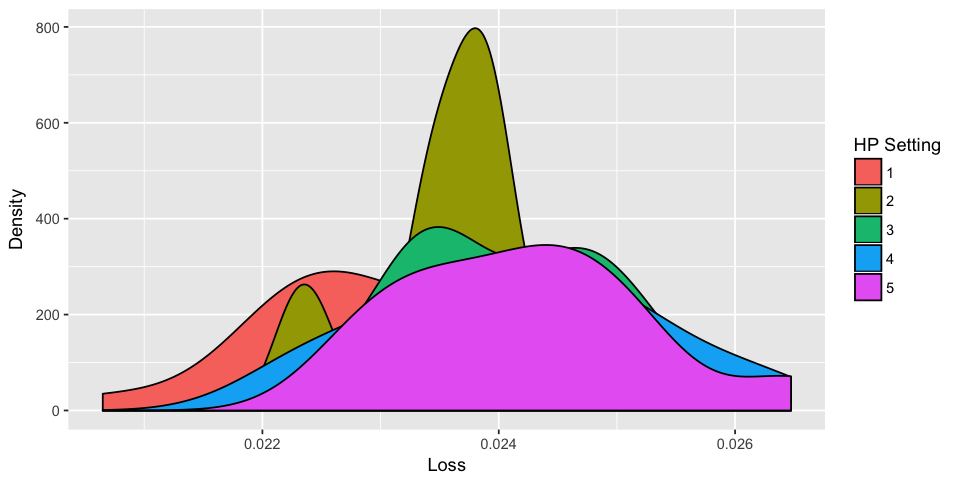

In [228]:
plot_groups(filter_by_anova(subsample_trials(subsample_groups(tbl, 150), 25), verbose=F, alpha=0.1))

[1] 0.068

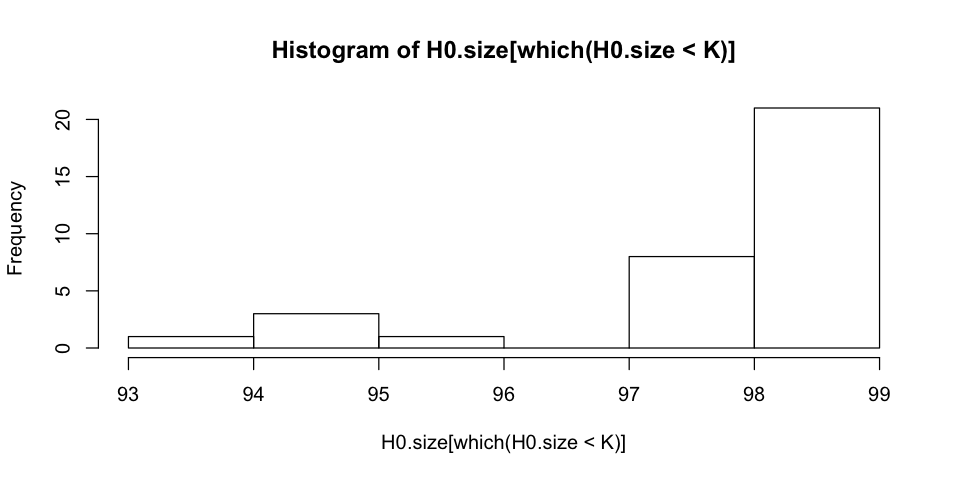

In [472]:
K <- 100
n <- 10
n.lambda <- c(3,6,9)
alpha <- 0.05
num.runs <- 500
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- FilterTrials(tbl=df, n.lambda=n.lambda, alpha=alpha)$trials
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
hist(H0.size[which(H0.size<K)])

[1] 0.04

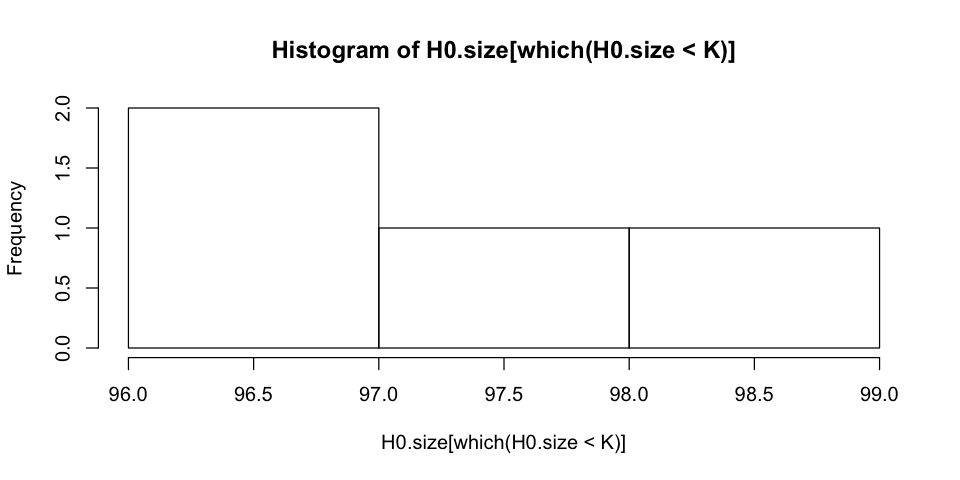

In [458]:
K <- 100
n <- 10
alpha <- 0.35
num.runs <- 100
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- filter_by_anova(df, alpha=alpha, verbose=F)
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
hist(H0.size[which(H0.size<K)])

In [ ]:
RejectByHolmBonf <- function(xbar, var.xbar, alpha=0.05){
    # Reject values in x via Holm-Bonferroni procedure
    # My own implementation.
    #
    # Args:
    #   x: vector of xbar values.
    #   var.x: variance associate with xbar values.
    #   alpha: type 1 error level
    #
    # Returns:
    #   values in x that were not rejected.
    K <- length(xbar)
    min.idx <- which.min(xbar)

    x.star <- xbar[min.idx]
    var.x.star <- var.xbar[min.idx]

    x.test <- xbar[-min.idx]
    var.x.test <- var.xbar[-min.idx]

    w.star <- (x.test - x.star)/sqrt(var.x.test + var.x.star)

    w <- rep(NA, K*(K-1)/2)
    count <- 1
    for(i in 1:(K-1)){
        for(j in (i+1):K){
            temp <- (xbar[i] - xbar[j])/sqrt(var.xbar[i] + var.xbar[j])
            w[count] <- abs(temp)
            count <- count + 1
        }
    }
    p <- 1.-pnorm(w)
    p.ordered <- sort(p)
    
    k <- 1:length(w)
    accept.test <- p.ordered > (alpha/(length(w) + 1 - k))
    
    if (sum(accept.test) == 0) {
        # Reject all
        accept.idxs <- c()
    } else if (sum(accept.test) == K-1) {
        # Accept all
        accept.idxs <- k
    } else {
        k.accept <- which(accept.test)[1]
        accept.p <- p.ordered[k.accept:length(w)]
        accept.idxs <- match(accept.p, p)
    }
    w.star.accepted <- intersect(w[accept.idxs], w.star)
    accept.original.idxs <- match(w.star.accepted, w.star)
    return(c(x.star, x.test[accept.original.idxs]))
}

# RejectByHolmBonf <- function(x, var.x, alpha=0.05, min.idx=NULL){
#     # Reject values in x via Holm-Bonferroni procedure
#     # My own implementation.
#     #
#     # Args:
#     #   x: vector of xbar values.
#     #   var.x: variance associate with xbar values.
#     #   alpha: type 1 error level
#     #
#     # Returns:
#     #   values in x that were not rejected.
#     K <- length(x)
    
#     if (is.null(min.idx)){
#         min.idx <- which.min(x)
#     }
    
#     x.star <- x[min.idx]
#     var.x.star <- var.x[min.idx]
    
#     x.test <- x[-min.idx]
#     var.x.test <- var.x[-min.idx]

#     w <- (x.test - x.star)/sqrt(var.x.test + var.x.star)
#     p <- 1.-pnorm(w)
    
#     p.ordered <- sort(p)
    
#     k <- 1:(K-1)
#     accept.test <- p.ordered > (alpha/(K - k))
    
#     if (sum(accept.test) == 0) {
#         # Reject all
#         accept.idxs <- c()
#     } else if (sum(accept.test) == K-1) {
#         # Accept all
#         accept.idxs <- k
#     } else {
#         k.accept <- which(accept.test)[1]
#         accept.p <- p.ordered[k.accept:(K-1)]
#         accept.idxs <- match(accept.p, p)
#     }
#     return(c(x.star, x.test[accept.idxs]))
# }

RejectByHolmBonfR <- function(x, var.x, alpha=0.05, min.idx=NULL){
    # Reject values in x via Holm-Bonferroni procedure
    # R implementation
    #
    # Args:
    #   x: vector of xbar values.
    #   var.x: variance associate with xbar values.
    #   alpha: type 1 error level
    #
    # Returns:
    #   values in x that were not rejected.
    N <- length(x)
    if (is.null(min.idx)){
        min.idx <- which.min(x)
    }
    
    x.star <- x[min.idx]
    var.x.star <- var.x[min.idx]
    
    x.test <- x[-min.idx]
    var.x.test <- var.x[-min.idx]

    w <- (x.test - x.star)/sqrt(var.x.test + var.x.star)
    p <- 1.-pnorm(w)
    accept <- p.adjust(p, "holm") > alpha
    
    return(c(x.star, x.test[accept]))
}


TestRejectByHolmBonf <- function() {
    N <- 100
    n <- 10
    num.runs <- 1000
    fp <- 0
    for (i in 1:num.runs) {
        x <- matrix(c(rep(1, n), rexp((N-1)*n, 1)), nrow=N, ncol=n, byrow = T)
        xbar <- apply(x, 1, mean)
        var.xbar <- apply(x, 1, var)/n
        xbar.notrejected <- RejectByHolmBonf(xbar[xbar>=1], var.xbar[xbar>=1], alpha=0.05)
        if (length(xbar.notrejected) < sum(xbar>=1)) {
            fp <- fp + 1
        }
    }
    print("TestRejectByHolmBonf")
    print(fp/num.runs > 0.03 && fp/num.runs < 0.06)
}

TestRejectByHolmBonf()


CalcPocockErrorAndSampleSize <- function (n, alpha){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        if (length(n) == 3) {
            alpha.dash <- rep(0.02317456, 3)
        } else if (length(n) == 5) {
            alpha.dash <- rep(0.01693147, 5)
        } else {
            information.fraction <- n/max(n)
            spent.error <- alpha * log(1+(exp(1)-1)*information.fraction)
            alpha.dash <- c(spent.error[1], diff(spent.error))
        }
        n.delta <- c(n[1], diff(n))
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}

TestCalcPocockErrorAndSampleSize <- function() {
    # Compare to values obtained from Lan paper
    # Should be c(2.1217, 2.1217, 2.1217, 2.1217, 2.1217)
    # as page 3 Table 1 from the paper
    n <- c(1,2,3,4,5)
    rval <- CalcPocockErrorAndSampleSize(n, 0.05)
    cval <- qnorm(1-rval$alpha.dash)
    print("TestCalcPocockErrorAndSampleSize")
    print(all(cval == rep(2.1217, 5)))
}
TestCalcPocockErrorAndSampleSize()

GenerateH0 <- function(psi, n.lambda, alpha, min.idx=NULL) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   List of null sets corresponding to each interim analysis.
    pocock <- CalcPocockErrorAndSampleSize(n.lambda, alpha)
    alpha.dash <- pocock$alpha.dash
    n.lambda.delta <- pocock$n.delta
    
    # H and H0 denote indices with respect to psi
    H0 <- list()
    H <- 1:length(psi)
    trials <- lapply(psi, sample, size=0)
    for (i in 1:length(n.lambda)){
        new.trials <- lapply(psi, sample, size=n.lambda.delta[i])
        trials <- mapply(c, trials, new.trials, SIMPLIFY=F)
        tau.hat <- unlist(lapply(trials, mean))
        nu.hat <- unlist(lapply(trials, var))
        if (n.lambda.delta[i] > 1){
            H0.tau <- RejectByHolmBonf(x=tau.hat[H], var.x=nu.hat[H]/n.lambda[i], alpha=alpha.dash[i], min.idx=min.idx)
        } else {
            H0.tau <- min(tau.hat[H])
        }
        H0[[i]] <- match(H0.tau, tau.hat)
        H <- H0[[i]]
    }
    return(list(H0=H0, trials=trials))
}

TestGenerateH0 <- function() {
    psi <- list()
    for(i in 1:50) {
        psi[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
    }
    test1 <- GenerateH0(psi, n.lambda=c(1), alpha=0.05)$H0[[1]] == 1
    test5 <- GenerateH0(psi, n.lambda=c(5), alpha=0.05)$H0[[1]] == 1
    test10 <- GenerateH0(psi, n.lambda=c(10), alpha=0.05)$H0[[1]] == 1
    test369 <- GenerateH0(psi, n.lambda=c(3,6,9), alpha=0.05)$H0[[1]] == 1
    print("TestGenerateH0")
    print(all(c(test1, test5, test10, test369)))
}
TestGenerateH0()

CalcNumTrials <- function (N, H0, n){
    # Calculate now many trials were used.
    #
    # Args:
    #   N: starting number of trials.
    #   H0: the null set(s) for each interim analysis as list.
    #   n: sample size at each interim analysis.
    #
    # Returns:
    #   The number of trials that were used.
    num.trials <- 0
    trials.per.analysis <- c(N, unlist(lapply(H0, length)))
    if (length(n) > 1){
        n.delta <- n - c(0, n[1:(length(n)-1)])
    } else {
        n.delta <- n
    }
    for (i in 1:length(n.delta)){
        num.trials <- num.trials + n.delta[i]*trials.per.analysis[i]
    }
    return(num.trials)
}
TestCalcNumTrials <- function() {
    N <- 100
    H0 <- list(`1`=c(1:50), `2`=1:10, `3`=1:5)
    n <- c(10, 20, 30)
    
    # should be 10*100 + 50*10 + 10*10
    print("TestCalcNumTrials")
    print(CalcNumTrials(N, H0, n) == 10*100 + 50*10 + 10*10)
}
TestCalcNumTrials()

EvalMetrics <- function(psi, n.lambda, alpha, num.runs, N, psi.test=NULL){
    # Generate paper results
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #   num.runs: number of simulations to run.
    #   best.trial: the index of the best trial in psi.
    #
    # Returns:
    #   List of paper metrics.
    lambda.star.in.H0 <- rep(NA, num.runs)
    lambda.star.test.in.H0 <- rep(NA, num.runs)
    size.H0 <- rep(NA, num.runs)
    lambda.in.H0c <- rep(NA, num.runs)
    lambda.test.in.H0c <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)

    for (j in 1:num.runs){
        psi.idxs <- sample(1:length(psi), N, replace = F)
        psi.sample <- psi[psi.idxs]
        
        mean.psi.sample <- unlist(lapply(psi.sample, mean))
        best.trial <- which.min(mean.psi.sample)
        
        H0 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)$H0
        
        lambda.star.in.H0[j] <- best.trial %in% H0[[length(n.lambda)]]
        size.H0[j] <- length(H0[[length(n.lambda)]])
        size.H0c <- N-size.H0[j]
        lambda.in.H0c[j] <- (size.H0c - !lambda.star.in.H0[j])/(N-1)
        num.trials[j] <- CalcNumTrials(N=N, H0=H0, n=n.lambda)
        
        if(!is.null(psi.test)) {
            psi.sample.test <- psi.test[psi.idxs]
            mean.psi.sample.test <- unlist(lapply(psi.sample.test, mean))
            best.trial.test <- which.min(mean.psi.sample.test)
            lambda.star.test.in.H0[j] <- best.trial.test %in% H0[[length(n.lambda)]]
            lambda.test.in.H0c[j] <- (size.H0c - !lambda.star.test.in.H0[j])/(N-1)
        }
        
    }
    if(!is.null(psi.test)) {
        return(list(lambda.star.in.H0=mean(lambda.star.in.H0),
                lambda.star.test.in.H0=mean(lambda.star.test.in.H0),
                size.H0=mean(size.H0),
                lambda.in.H0c=mean(lambda.in.H0c),
                lambda.test.in.H0c=mean(lambda.test.in.H0c),
                avg.num.trials=mean(num.trials)))
    } else {
        return(list(lambda.star.in.H0=mean(lambda.star.in.H0),
                size.H0=mean(size.H0),
                lambda.in.H0c=mean(lambda.in.H0c),
                avg.num.trials=mean(num.trials)))
    }
    
}
TestEvalMetrics <- function() {
    psi <- list()
    psi.test <- list()
    for(i in 1:50) {
        psi[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
        psi.test[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
    }
    psi.test[[1]] <- psi.test[[1]] + 1
    rval <- EvalMetrics(psi, n.lambda=c(3,6,9), alpha=0.05, num.runs=100, N=length(psi), psi.test=psi.test)
    rval$avg.num.trials == 50*3 + 1*3 + 1*3
    print("TestEvalMetrics")
    print(rval$lambda.star.in.H0 == 1.)
    print(rval$size.H0 == 1.)
    print(rval$lambda.in.H0c == 1.)
    print(rval$avg.num.trials == 50*3 + 1*3 + 1*3)
    print(rval$lambda.star.test.in.H0 == 0.)
#     print(rval$lambda.test.in.H0c == 1.)
    
}
TestEvalMetrics()

EvalComparisonDiff <- function(psi, n.lambda, alpha, num.runs, N, post.opt.runs=25, sample.lambda=T, psi.test=NULL){
    # Simulate how many times one would declare a significant
    # difference between the method and itself.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #   num.runs: number of simulations to run.
    #   best.trial: the index of the best trial in psi.
    #   post.opt.runs: how many times to run the best trial to get CI.
    #
    # Returns:
    #   List of paper metrics.
    diff <- rep(NA, num.runs)
    
    for (j in 1:num.runs){
        psi.idxs <- sample(1:length(psi), N, replace = F)
        psi.sample <- psi[psi.idxs]
        if(!is.null(psi.test)){
            psi.sample.test <- psi.test[psi.idxs]
        }
        
#         psi.shuffle <- lapply(psi.sample, sample, size=25, replace=F)
#         psi.1 <- lapply(psi.shuffle, `[`, i =1:12)
#         psi.2 <- lapply(psi.shuffle, `[`, i =13:25)
        
        rval.1 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)
        rval.2 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)

#         selected.trial.1 <- sample(rval.1$H0[[length(n.lambda)]], 1)
#         selected.trial.2 <- sample(rval.2$H0[[length(n.lambda)]], 1)

        selected.trial.1 <- rval.1$H0[[length(n.lambda)]]
        selected.trial.2 <- rval.2$H0[[length(n.lambda)]]
        selected.trial.1 <- ifelse(length(selected.trial.1)>1 && sample.lambda, sample(selected.trial.1, 1), selected.trial.1[1])
        selected.trial.2 <- ifelse(length(selected.trial.2)>1 && sample.lambda, sample(selected.trial.2, 1), selected.trial.2[1])
        if(!is.null(psi.test)){
            post.trial.1 <- psi.sample.test[[selected.trial.1]][1:25]
            post.trial.2 <- psi.sample.test[[selected.trial.2]][1:25]
        } else {
            post.trial.1 <- psi.sample[[selected.trial.1]][1:25]
            post.trial.2 <- psi.sample[[selected.trial.2]][1:25]
        }

        
        diff[j] <- mean(post.trial.1)-mean(post.trial.2)
    }
    return(diff)
}

EvalMeanVar <- function(psi, n.lambda, alpha, num.runs, N, post.opt.runs=25, sample.lambda=T, psi.test=NULL){
    # Simulate the mean and variance across expected prediction
    # error one would get from repeatedly running the method.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #   num.runs: number of simulations to run.
    #   sample.lambda: whether to sample lambda.star from H0 or
    #       take the best observed.
    #   post.opt.runs: how many times to run the best trial to get CI.
    #
    # Returns:
    #   List of mean and variance
    expected.prediction.error <- rep(NA, num.runs)
    
    for (j in 1:num.runs){
        psi.idxs <- sample(1:length(psi), N, replace = F)
        psi.sample <- psi[psi.idxs]
        if(!is.null(psi.test)){
            psi.sample.test <- psi.test[psi.idxs]
        }
        
        rval <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)

        H0 <- rval$H0[[length(n.lambda)]]
        lambda.star <- ifelse(length(H0)>1 && sample.lambda, sample(H0, 1), H0[1])

        if(!is.null(psi.test)){
            lambda.star.mc.samples <- sample(psi.sample.test[[lambda.star]], post.opt.runs, replace=F)
        } else {
            lambda.star.mc.samples <- sample(psi.sample[[lambda.star]], post.opt.runs, replace=F)
        }

        expected.prediction.error[j] <- mean(lambda.star.mc.samples)
    }
    return(list(mean=mean(expected.prediction.error),
                var=var(expected.prediction.error),
                expected.prediction.error=expected.prediction.error))
}

# Toy Examples

## Type I Error

In [ ]:
HolmBonfTypeOneErrorNormal <- function() {
    N <- 100
    n <- 10
    num.runs <- 100
    fp <- 0
    l <- rep(NA, num.runs)
    l.H0 <- rep(NA, num.runs)
    for (i in 1:num.runs) {
        x <- matrix(rnorm((N)*n, mean=0, sd=1), nrow=N, ncol=n, byrow = T)
        xbar <- apply(x, 1, mean)
        var.xbar <- apply(x, 1, var)/n
        xbar.notrejected <- RejectByHolmBonf(xbar, var.xbar, alpha=0.05)
        if (length(xbar.notrejected) < N) {
            fp <- fp + 1
        }
        l[i] <- N
        l.H0[i] <- length(xbar.notrejected)
    }
    cat(paste("Type I Error (Normal): ", fp/num.runs))
    return(list(l=l, l.H0=l.H0))
}
HolmBonfTypeOneErrorNormal()

In [ ]:
HolmBonfTypeOneErrorNormalCorrected <- function() {
    N <- 100
    n <- 10
    num.runs <- 10000
    fp <- 0
    l <- rep(NA, num.runs)
    l.H0 <- rep(NA, num.runs)
    for (i in 1:num.runs) {
        x <- matrix(rnorm((N)*n, mean=0, sd=1), nrow=N, ncol=n, byrow = T)
        xbar <- apply(x, 1, mean)
        var.xbar <- apply(x, 1, var)/n
        min.idx <- 1
        xbar.notrejected <- RejectByHolmBonfR(xbar, var.xbar, alpha=0.05, min.idx=min.idx)
        if (length(xbar.notrejected) < N) {
            fp <- fp + 1
        }
        l[i] <- N
        l.H0[i] <- length(xbar.notrejected)
    }
    cat(paste("Type I Error (Normal): ", fp/num.runs))
    return(list(l=l, l.H0=l.H0))
}
rval <- HolmBonfTypeOneErrorNormalCorrected()

In [ ]:
HolmBonfTypeOneErrorNormalPairwise <- function() {
    K <- 100
    n <- 50
    num.runs <- 500
    fp <- 0
    l <- rep(NA, num.runs)
    l.H0 <- rep(NA, num.runs)
    for (i in 1:num.runs) {
        x <- matrix(NA, nrow=K, ncol=n)
        x[1,] <- rnorm(n)
        for(j in 2:K){
            x[j,] <- rnorm(n)
            while(mean(x[j,]) < mean(x[1,])){
                x[j,] <- rnorm(n)
            }
        }
        xbar <- apply(x, 1, mean)
        var.xbar <- apply(x, 1, var)/n
        xbar.notrejected <- RejectByHolmBonf(xbar, var.xbar, alpha=0.05)
        l[i] <- K
        l.H0[i] <- length(xbar.notrejected)
    }
    cat(paste("Type I Error (Normal): ", mean(l != l.H0)))
    return(list(l=l, l.H0=l.H0))
}
rval <- HolmBonfTypeOneErrorNormalPairwise()

In [ ]:
x <- matrix(rnorm(100), 10, 10, byrow = T)

In [ ]:
x[1,]

In [ ]:
split(x, rep(1:nrow(x), each = ncol(x)))[[1]]

In [ ]:
?split

In [ ]:
ProcedureTypeOneError <- function() {
    K <- 100
    n <- 25
    n.lambda <- c(3,6,9)
    num.runs <- 100
    fp <- 0
    l <- rep(NA, num.runs)
    l.H0 <- rep(NA, num.runs)
    for (i in 1:num.runs) {
        x.sample <- matrix(rnorm((K)*n, mean=0, sd=1), nrow=K, ncol=n, byrow = T)
        x <- split(x.sample, rep(1:nrow(x.sample), each = ncol(x.sample)))
        H0 <- GenerateH0(x, n.lambda=n.lambda, alpha=alpha, min.idx=1)$H0
        l[i] <- K
        l.H0[i] <- length(H0[[length(n.lambda)]])
    }
    cat(paste("Type I Error (Normal): ", mean(l != l.H0)))
    return(list(l=l, l.H0=l.H0))
}
rval <- ProcedureTypeOneError()

In [ ]:
ProcedureTypeOneError <- function() {
    K <- 100
    n <- 50
    n.lambda <- c(3,6,9)
    num.runs <- 100
    fp <- 0
    l <- rep(NA, num.runs)
    l.H0 <- rep(NA, num.runs)
    for (i in 1:num.runs) {
        x <- list()
        x[[1]] <- rnorm(n)
        for(j in 2:K){
            x[[j]] <- rnorm(n)
            while(mean(x[[j]]) < mean(x[[1]])){
                x[[j]] <- rnorm(n)
            }
        }
        H0 <- GenerateH0(x, n.lambda=n.lambda, alpha=alpha)$H0
        l[i] <- K
        l.H0[i] <- length(H0[[length(n.lambda)]])
    }
    cat(paste("Type I Error (Normal): ", mean(l != l.H0)))
    return(list(l=l, l.H0=l.H0))
}
rval <- ProcedureTypeOneError()

In [ ]:
rval$l.H0

# MNIST

In [7]:
results <- read.csv("./mnistcnn/mnist_results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')

dropout.unique <- unique(completed$dropout)
num.distinct.values <- length(dropout.unique)
psi.mnist <- list()
group.idx <- 1
psi.idx <- 1
for (group.idx in 1:num.distinct.values){
    this.df <- subset(completed, dropout == dropout.unique[group.idx])
    if (length(this.df$Objective) == 25){
        psi.mnist[[psi.idx]] = this.df$Objective
        psi.idx <- psi.idx + 1
    } else {
        print(paste("Skipping", group.idx, "with number of repetitions", length(this.df$Objective)))
    }
}

num.groups <- length(psi.mnist)

[1] "Skipping 51 with number of repetitions 1"
[1] "Skipping 102 with number of repetitions 1"
[1] "Skipping 145 with number of repetitions 24"
[1] "Skipping 146 with number of repetitions 24"
[1] "Skipping 148 with number of repetitions 24"
[1] "Skipping 161 with number of repetitions 22"


In [ ]:
num.groups

In [ ]:
mean.psi <- unlist(lapply(psi.mnist, mean))
lambda.star <- which.min(mean.psi)

In [ ]:
num.samples <- 5
# grp.idxs <- match(sort(sapply(psi.mnist, mean)), sapply(psi.mnist, mean))[1:num.samples]
mean.sample <- sample(sapply(psi.mnist, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.mnist, mean))[1:num.samples]
# grp.idxs <- sample(1:num.groups, num.samples)
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- psi.mnist[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste(grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Minimum Validation Loss", y="Density")
p

In [ ]:
ggsave("figures/MNIST-density.pdf", plot=p, width=8, height=4)

In [ ]:
N <- 50
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

In [ ]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 100
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

In [ ]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 150
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

In [ ]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

# Average Expected Difference

In [ ]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=1000, N=172, post.opt.runs=25)

In [ ]:
round(mean(abs(diff)), 5)

# IMDB

In [ ]:
completed <- read.csv("./imdblstm//imdb_results.csv", header = T)
test.acc <- read.csv("./imdblstm//imdb_results_test.csv", header = T)


dropout_embedding.unique <- unique(completed$dropout_embedding)
num.distinct.values <- length(dropout_embedding.unique)
psi.imdb <- list()
psi.imdb.test <- list()
group.idx <- 1
psi.idx <- 1
for (group.idx in 1:num.distinct.values){
    this.df <- subset(completed, dropout_embedding == dropout_embedding.unique[group.idx])
    this.test.df <- subset(test.acc, dropout_embedding == dropout_embedding.unique[group.idx])
    if (length(this.df$Objective) == 25){
        psi.imdb[[psi.idx]] = 1.-this.df$Objective
        psi.imdb.test[[psi.idx]] = 1.-this.test.df$test_acc
        psi.idx <- psi.idx + 1
    } else {
        print(paste("Skipping", group.idx, "with number of repetitions", length(this.df$Objective)))
    }
}

num.groups <- length(psi.imdb)

In [ ]:
num.groups

In [ ]:
mean.psi <- unlist(lapply(psi.imdb, mean))
lambda.star <- which.min(mean.psi)

In [ ]:
num.samples <- 5
# grp.idxs <- match(sort(sapply(psi.mnist, mean)), sapply(psi.mnist, mean))[1:num.samples]
mean.sample <- sample(sapply(psi.imdb, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.imdb, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- 1.-psi.imdb[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("lambda", grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Validation Accuracy", y="Density")
p

In [ ]:
ggsave("figures/IMDB-density.pdf", plot=p, width=8, height=4)

In [ ]:
N <- 50
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

In [ ]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 100
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

In [ ]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 150
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

In [ ]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

# Mean and Var of Results

In [ ]:
rval.seq <- EvalMeanVar(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F)

In [ ]:
rval.seq$mean
rval.seq$var

In [ ]:
# hist(rval.seq$expected.prediction.error)

In [ ]:
rval.reg <- EvalMeanVar(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25)

In [ ]:
rval.reg$mean
rval.reg$var

In [ ]:
# hist(rval.reg$expected.prediction.error)

# Mean and Var of Results Test

In [ ]:
rval.seq <- EvalMeanVar(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F)

In [ ]:
rval.seq$mean
rval.seq$var

In [ ]:
# hist(rval.seq$expected.prediction.error)

In [ ]:
rval.reg <- EvalMeanVar(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25)

In [ ]:
rval.reg$mean
rval.reg$var

In [ ]:
# hist(rval.reg$expected.prediction.error)

# Mean and Var of Results

In [ ]:
rval.seq <- EvalMeanVar(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F, psi.test=psi.imdb.test)

In [ ]:
rval.seq$mean
rval.seq$var

In [ ]:
# hist(rval.seq$expected.prediction.error)

In [ ]:
rval.reg <- EvalMeanVar(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25, psi.test=psi.imdb.test)

In [ ]:
rval.reg$mean
rval.reg$var

In [ ]:
# hist(rval.reg$expected.prediction.error)

# Average Expected Difference

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = T)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = T, psi.test=psi.imdb.test)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F, psi.test=psi.imdb.test)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25, psi.test=psi.imdb.test)

In [ ]:
round(mean(abs(diff)), 5)

# Boston

In [ ]:
results <- read.csv("./bostongbrt/boston_results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
completed <- completed[order(completed$Trial.ID),]

subsample.unique <- unique(completed$subsample)
num.groups <- length(subsample.unique)

psi.boston <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, subsample == subsample.unique[i])
    psi.boston[[i]] <- this.df$Objective
}
lambda.star <- which.min(unlist(lapply(psi.boston, mean)))

In [ ]:
num.samples <- 5
mean.sample <- sample(sapply(psi.boston, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.boston, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- psi.boston[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i], sep="")
#     plot.df$Group[((i-1)*25 + 1):((i)*25)] <- TeX(paste("$\\lambda_", grp.idxs[i], "$", sep=""))
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Validation Mean Squared Error", y="Density")
p

In [ ]:
ggsave("figures/Boston-density.pdf", plot=p, width=8, height=4)

In [ ]:
N <- 50

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

In [ ]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 100

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

In [ ]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 150

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

In [ ]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

# Mean and Var of Results

In [ ]:
length(psi.boston)

In [ ]:
rval.seq <- EvalMeanVar(psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=100, post.opt.runs=25, sample.lambda = F)

In [ ]:
rval.seq$mean
rval.seq$var

In [ ]:
# hist(rval.seq$expected.prediction.error)

In [ ]:
rval.reg <- EvalMeanVar(psi.boston, n.lambda=c(1), alpha=0.05, num.runs=1000, N=700, post.opt.runs=25)

In [ ]:
rval.reg$mean
rval.reg$var

In [ ]:
# hist(rval.reg$expected.prediction.error)

# Average Expected Difference

In [ ]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(1), alpha=0.05, num.runs=1000, N=320, post.opt.runs=25)

In [ ]:
round(mean(abs(diff)), 5)

# Cartpole

In [ ]:
completed <- read.csv("./cartpole/cartpole_results.csv", header = T)
completed <- completed[order(completed$Trial.ID),]

gamma.unique <- unique(completed$gamma)
num.groups <- length(gamma.unique)

psi.cartpole <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, gamma == gamma.unique[i])
    psi.cartpole[[i]] <- 1-this.df$auc
}
lambda.star <- which.min(unlist(lapply(psi.cartpole, mean)))

In [ ]:
num.samples <- 5
grp.idxs <- match(sort(sapply(psi.cartpole, mean)), sapply(psi.cartpole, mean))[1:num.samples]
# mean.sample <- sample(sapply(psi.cartpole, mean), 100)
# grp.idxs <- match(sort(mean.sample), sapply(psi.cartpole, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- 1.-psi.cartpole[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="AUC", y="Density")
p

In [ ]:
ggsave("figures/Cartpole-density.pdf", plot=p, width=8, height=4)

In [ ]:
N <- 50

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

In [ ]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 100

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

In [ ]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

In [ ]:
N <- 150

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

In [ ]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

# Mean and Var of Results

In [ ]:
length(psi.cartpole)

In [ ]:
rval.seq <- EvalMeanVar(psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [ ]:
rval.seq$mean
rval.seq$var

In [ ]:
# hist(rval.seq$expected.prediction.error)

In [ ]:
rval.reg <- EvalMeanVar(psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=1000, N=159, post.opt.runs=25)

In [ ]:
rval.reg$mean
rval.reg$var

In [ ]:
# hist(rval.reg$expected.prediction.error)

# Average Expected Difference

In [ ]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [ ]:
round(mean(abs(diff)), 5)

In [ ]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=1000, N=159, post.opt.runs=25)

In [ ]:
round(mean(abs(diff)), 5)

# CIFAR10 Grid Search

In [ ]:
results <- read.csv("./cifar10resnet/cifar10_resnet.csv", header = T)
completed <- results[results$Status=="COMPLETED",]
completed <- completed[order(completed$Trial.ID),]

lr.unique <- unique(completed$lr)
num.groups <- length(lr.unique)
lr <- rep(NA, 10)

psi.cifar <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, lr == lr.unique[i])
    psi.cifar[[i]] <- 1-this.df$Objective
    lr[i] <- lr.unique[i]
}
lambda.star <- which.min(unlist(lapply(psi.cifar, mean)))

In [ ]:
psi.cifar <- psi.cifar[1:5]
num.groups <- length(psi.cifar)
lr <- lr[1:5]

In [ ]:
num.samples <- 5
grp.idxs <- 1:num.groups
plot.df <- data.frame(ValAccuracy=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$ValAccuracy[((i-1)*25 + 1):((i)*25)] <- 1.-psi.cifar[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i],":", lr.unique[i], sep="")
}
p <- ggplot(plot.df, aes(x=ValAccuracy, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="AUC", y="Density")
p